In [1]:
from pyspark.sql import *
from pyspark.sql.types import Row
from pyspark.sql import functions as f
from pyspark.sql.functions import unix_timestamp, from_unixtime
from pyspark.sql.functions import *
from pyspark.sql.types import *
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from pyspark.ml.fpm import FPGrowth
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
from datetime import datetime, timedelta

In [2]:
df = spark.read.csv("superstore.csv", inferSchema = True, header = True)
print(df.count())
df.printSchema()

51290
root
 |-- Row ID: integer (nullable = true)
 |-- Order ID: string (nullable = true)
 |-- Order Date: string (nullable = true)
 |-- Ship Date: string (nullable = true)
 |-- Ship Mode: string (nullable = true)
 |-- Customer ID: string (nullable = true)
 |-- Customer Name: string (nullable = true)
 |-- Segment: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Postal Code: integer (nullable = true)
 |-- Market: string (nullable = true)
 |-- Region: string (nullable = true)
 |-- Product ID: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Sub-Category: string (nullable = true)
 |-- Product Name: string (nullable = true)
 |-- Sales: string (nullable = true)
 |-- Quantity: string (nullable = true)
 |-- Discount: string (nullable = true)
 |-- Profit: double (nullable = true)
 |-- Shipping Cost: double (nullable = true)
 |-- Order Priority: string (nullable = true)



In [3]:
data = df.drop("Row ID", "City", "State", "Postal Code", "Region", "Customer Name", "Order Priority", "Discount", "Shipping Cost", "Ship Mode", "Ship Date")
data = data.withColumn("Order Date", f.regexp_replace("Order Date", "/", "-"))
data = data.withColumn("Order Date",to_date(data["Order Date"], 'dd-MM-yyyy'))
data = data.withColumn("Order Date", data["Order Date"].cast(StringType()))
data = data.withColumn("Month", data["Order Date"].substr(0, 7))
data = data.withColumn("Quantity", data["Quantity"].cast("long"))
data = data.withColumn("Sales", data["Sales"].cast("double"))
print(data.printSchema())

root
 |-- Order ID: string (nullable = true)
 |-- Order Date: string (nullable = true)
 |-- Customer ID: string (nullable = true)
 |-- Segment: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Market: string (nullable = true)
 |-- Product ID: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Sub-Category: string (nullable = true)
 |-- Product Name: string (nullable = true)
 |-- Sales: double (nullable = true)
 |-- Quantity: long (nullable = true)
 |-- Profit: double (nullable = true)
 |-- Month: string (nullable = true)

None


# Most ordered products

In [4]:
prod = data.select(data["Product ID"], data["Quantity"])
most_prod = prod.groupby("Product ID").sum().withColumnRenamed("sum(Quantity)", "Total Ordered")
topten=most_prod.orderBy("Total Ordered" ,ascending = False).limit(20)
topten.show()

print(prod.count())
print(most_prod.count())

+---------------+-------------+
|     Product ID|Total Ordered|
+---------------+-------------+
|OFF-ST-10002756|         4381|
|FUR-FU-10001488|         2264|
|FUR-FU-10002298|         2061|
|OFF-ST-10004804|         1395|
|OFF-BI-10001597|         1209|
|OFF-EN-10001453|          935|
|OFF-ST-10003994|          846|
|OFF-BI-10002133|          830|
|OFF-PA-10002222|          591|
|FUR-FU-10001602|          543|
|FUR-FU-10000305|          466|
|OFF-SU-10000898|          455|
|OFF-PA-10000241|          454|
|OFF-ST-10002289|          404|
|FUR-FU-10001475|          330|
|OFF-PA-10000380|          279|
|OFF-BI-10000309|          266|
|OFF-PA-10001509|          265|
|FUR-FU-10003878|          250|
|OFF-PA-10001776|          242|
+---------------+-------------+

51290
10292


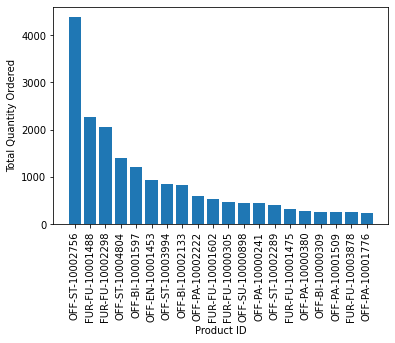

In [5]:
p = topten.select(topten["Product ID"])
o = topten.select(topten["Total Ordered"])
l1 = [row["Product ID"] for row in p.collect()]
l2 = [row["Total Ordered"] for row in o.collect()]
plt.bar(l1, l2)
plt.xticks(l1,rotation="vertical")
plt.xlabel("Product ID")
plt.ylabel("Total Quantity Ordered")
plt.savefig('product_orders.png', dpi=300, bbox_inches='tight')
plt.show()

# Most Ordered Category

### Most Ordered Sub-Category 

In [6]:
subcatg = data.select(data["Sub-Category"], data["Quantity"])
most_subcatg = subcatg.groupBy(subcatg["Sub-Category"]).sum().withColumnRenamed("sum(Quantity)", "Total Ordered")
most_subcatg.orderBy(most_subcatg["Total Ordered"], ascending = False).show()

+------------+-------------+
|Sub-Category|Total Ordered|
+------------+-------------+
|     Binders|        23986|
|     Storage|        23850|
| Furnishings|        17282|
|         Art|        16301|
|       Paper|        15405|
|      Chairs|        12336|
|      Phones|        12082|
| Accessories|        10946|
|   Envelopes|         9484|
|      Labels|         9322|
|    Supplies|         9200|
|   Fasteners|         8389|
|   Bookcases|         8310|
|     Copiers|         7454|
|  Appliances|         6078|
|    Machines|         4906|
|      Tables|         3083|
+------------+-------------+



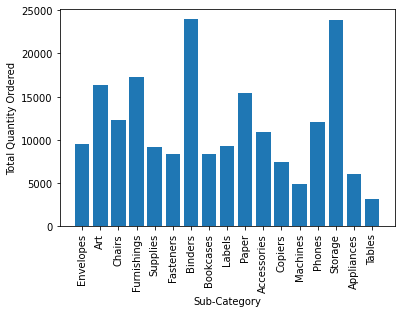

In [7]:
p = most_subcatg.select(most_subcatg["Sub-Category"])
o = most_subcatg.select(most_subcatg["Total Ordered"])
l1 = [row["Sub-Category"] for row in p.collect()]
l2 = [row["Total Ordered"] for row in o.collect()]
plt.bar(l1, l2)
plt.xticks(l1,rotation="vertical")
plt.xlabel("Sub-Category")
plt.ylabel("Total Quantity Ordered")
plt.show()

### Most Ordered Category 

In [8]:
catg = data.select(data["Category"], data["Quantity"])
most_catg = catg.groupBy(catg["Category"]).sum().withColumnRenamed("sum(Quantity)", "Total Ordered")
most_catg.orderBy(most_catg["Total Ordered"], ascending = False).show()

+---------------+-------------+
|       Category|Total Ordered|
+---------------+-------------+
|Office Supplies|       122015|
|      Furniture|        41011|
|     Technology|        35388|
+---------------+-------------+



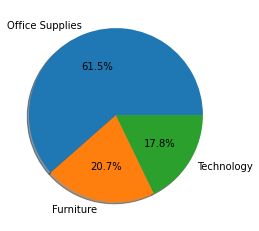

In [9]:
p = most_catg.select(most_catg["Category"])
o = most_catg.select(most_catg["Total Ordered"])
l1 = [row["Category"] for row in p.collect()]
l2 = [row["Total Ordered"] for row in o.collect()]

sizes=[122015,41011,35388]
labels="Office Supplies","Furniture","Technology"
plt.pie(sizes,labels=labels,shadow=True,autopct='%1.1f%%')
plt.savefig('category_orders.png', dpi=300, bbox_inches='tight')
plt.show()

# Country with the most orders

In [42]:
country = data.select(data["Country"], data["Order ID"])
most_country = country.distinct().groupBy(country["Country"]).count().withColumnRenamed("count", "Total Ordered")
most_country.orderBy(most_country["Total Ordered"], ascending = False).show()

+------------------+-------------+
|           Country|Total Ordered|
+------------------+-------------+
|     United States|         5009|
|         Australia|         1420|
|            Mexico|         1329|
|            France|         1222|
|             China|          925|
|           Germany|          907|
|             India|          785|
|            Brazil|          784|
|    United Kingdom|          775|
|         Indonesia|          698|
|            Turkey|          632|
|             Italy|          529|
|             Spain|          429|
|           Nigeria|          410|
|Dominican Republic|          389|
|       El Salvador|          375|
|              Cuba|          369|
|          Honduras|          349|
|       Philippines|          326|
|         Nicaragua|          315|
+------------------+-------------+
only showing top 20 rows



In [43]:
countries=most_country.rdd.map(lambda x: x[0]).collect()
vs=most_country.rdd.map(lambda x: x[1]).collect()

dt=[dict(type="choropleth", autocolorscale=True, locations=countries, z=vs, locationmode="country names", text=countries, colorbar= dict(title='Orders'))]
layout=dict(geo=dict(scope="world", projection=dict(type="natural earth"), showlakes=True, lakecolor='rgb(0,0,255)'))

fig=dict(data=dt, layout=layout)
pio.show(fig)

# Market with the most orders

In [12]:
market = data.select(data["Market"], data["Quantity"])
most_market = market.groupBy(market["Market"]).sum().withColumnRenamed("sum(Quantity)", "Total Ordered")
most_market.orderBy(most_market["Total Ordered"], ascending = False).show()

+------+-------------+
|Market|Total Ordered|
+------+-------------+
|    US|        57975|
|  APAC|        41226|
| LATAM|        38526|
|    EU|        37773|
|  EMEA|        11517|
|Africa|        10564|
|Canada|          833|
+------+-------------+



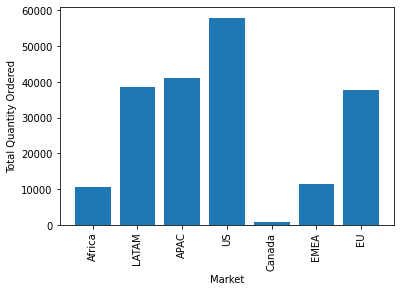

In [13]:
p = most_market.select(most_market["Market"])
o = most_market.select(most_market["Total Ordered"])
l1 = [row["Market"] for row in p.collect()]
l2 = [row["Total Ordered"] for row in o.collect()]
plt.bar(l1, l2)
plt.xticks(l1,rotation="vertical")
plt.xlabel("Market")
plt.ylabel("Total Quantity Ordered")
plt.show()

# Segment with most orders

In [14]:
segm = data.select(data["Segment"], data["Quantity"])
most_segm = segm.groupBy(segm["Segment"]).sum().withColumnRenamed("sum(Quantity)", "Total Ordered")
most_segm.orderBy(most_segm["Total Ordered"], ascending = False).show()

+-----------+-------------+
|    Segment|Total Ordered|
+-----------+-------------+
|   Consumer|       100554|
|  Corporate|        61548|
|Home Office|        36312|
+-----------+-------------+



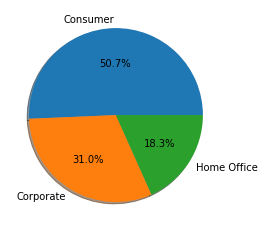

In [15]:
p = most_segm.select(most_segm["Segment"])
o = most_segm.select(most_segm["Total Ordered"])
l1 = [row["Segment"] for row in p.collect()]
l2 = [row["Total Ordered"] for row in o.collect()]

sizes=[100554, 61548, 36312]
labels= "Consumer", "Corporate", "Home Office"
plt.pie(sizes,labels=labels,shadow=True,autopct='%1.1f%%')
plt.savefig('segment_orders.png', dpi=300, bbox_inches='tight')
plt.show()

# Most Profitable Products

In [16]:
profit = data.select(data["Product ID"], data["Profit"])
prod_profit = profit.groupBy(profit["Product ID"]).sum().withColumnRenamed("sum(Profit)", "Total Profit")
top = prod_profit.orderBy(prod_profit["Total Profit"], ascending = False).limit(20)
#print(top.show())
mix = topten.join(top, "Product ID", "full")
print(mix.orderBy(mix["Total Ordered"], ascending = False).show())
print(mix.orderBy(mix["Total Profit"], ascending = False).show())

+---------------+-------------+------------+
|     Product ID|Total Ordered|Total Profit|
+---------------+-------------+------------+
|OFF-ST-10002756|         4381|        null|
|FUR-FU-10001488|         2264|        null|
|FUR-FU-10002298|         2061|        null|
|OFF-ST-10004804|         1395|        null|
|OFF-BI-10001597|         1209|        null|
|OFF-EN-10001453|          935|        null|
|OFF-ST-10003994|          846|        null|
|OFF-BI-10002133|          830|        null|
|OFF-PA-10002222|          591|        null|
|FUR-FU-10001602|          543|        null|
|FUR-FU-10000305|          466|        null|
|OFF-SU-10000898|          455|        null|
|OFF-PA-10000241|          454|        null|
|OFF-ST-10002289|          404|        null|
|FUR-FU-10001475|          330|        null|
|OFF-PA-10000380|          279|        null|
|OFF-BI-10000309|          266|        null|
|OFF-PA-10001509|          265|        null|
|FUR-FU-10003878|          250|        null|
|OFF-PA-10

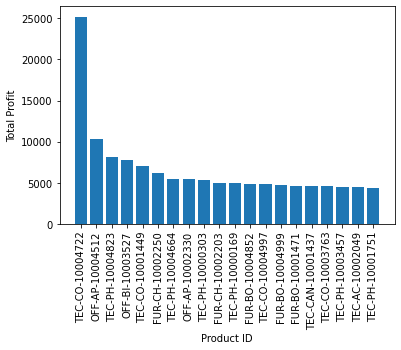

In [17]:
p = top.select(top["Product ID"])
o = top.select(top["Total Profit"])
l1 = [row["Product ID"] for row in p.collect()]
l2 = [row["Total Profit"] for row in o.collect()]
plt.bar(l1, l2)
plt.xticks(l1,rotation="vertical")
plt.xlabel("Product ID")
plt.ylabel("Total Profit")
plt.savefig('prod_profit.png', dpi=300, bbox_inches='tight')
plt.show()

# Most Profit per Category

### Sub-Category

In [18]:
sub_profit = data.select(data["Sub-Category"], data["Profit"])
most_sub_porfit = sub_profit.groupBy(sub_profit["Sub-Category"]).sum().withColumnRenamed("sum(Profit)", "Total Profit")
most_sub_porfit.orderBy(most_sub_porfit["Total Profit"], ascending = False).show()

+------------+------------------+
|Sub-Category|      Total Profit|
+------------+------------------+
|     Copiers|258567.54817999998|
|      Phones|216650.35429999995|
|   Bookcases|161924.41950000005|
|  Appliances|141680.58940000008|
|      Chairs|140396.26750000002|
| Accessories|129626.30619999992|
|     Storage|       108712.5717|
|     Binders| 72266.90400000004|
|    Machines|58867.872999999985|
|         Art|        57953.9109|
|       Paper| 57949.67439999999|
| Furnishings|48202.579900000004|
|   Envelopes|29098.208699999996|
|    Supplies| 22424.99709999999|
|      Labels|15010.511999999992|
|   Fasteners|11518.543700000002|
|      Tables|-64083.38870000001|
+------------+------------------+



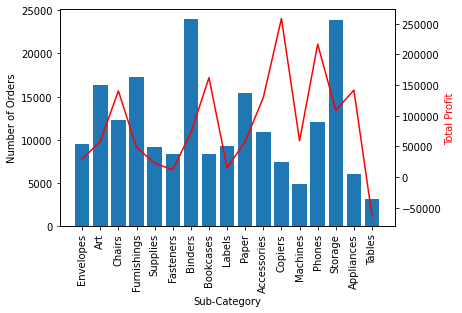

In [19]:
# p = most_sub_porfit.select(most_sub_porfit["Sub-Category"])
# o = most_sub_porfit.select(most_sub_porfit["Total Profit"])
# l1 = [row["Sub-Category"] for row in p.collect()]
# l2 = [row["Total Profit"] for row in o.collect()]
# plt.bar(l1, l2)
# plt.xticks(l1,rotation="vertical")
# plt.xlabel("Sub-Category")
# plt.ylabel("Total Profit")
# plt.show()

p = most_subcatg.select(most_subcatg["Sub-Category"])
o = most_subcatg.select(most_subcatg["Total Ordered"])
l1 = [row["Sub-Category"] for row in p.collect()]
l2 = [row["Total Ordered"] for row in o.collect()]

m = most_sub_porfit.select(most_sub_porfit["Sub-Category"])
n = most_sub_porfit.select(most_sub_porfit["Total Profit"])
l3 = [row["Sub-Category"] for row in m.collect()]
l4 = [row["Total Profit"] for row in n.collect()]

fig,ax2=plt.subplots()

ax1=ax2.twinx()
ax2.bar(l1, l2)
ax1.plot(l3, l4, 'r')
ax2.set_xlabel("Sub-Category")
ax2.set_ylabel("Number of Orders")
ax1.set_ylabel("Total Profit", color = "r")
ax2.set_xticklabels(l1,rotation='vertical')
plt.savefig('Sub-Category.png', dpi=300, bbox_inches='tight')
plt.show()

### Category

In [20]:
cat_profit = data.select(data["Category"], data["Profit"])
most_cat_profit = cat_profit.groupBy(cat_profit["Category"]).sum().withColumnRenamed("sum(Profit)", "Total Profit")
most_cat_profit.orderBy(most_cat_profit["Total Profit"], ascending = False).show()

+---------------+------------------+
|       Category|      Total Profit|
+---------------+------------------+
|     Technology| 663712.0816800011|
|Office Supplies| 516615.9118999997|
|      Furniture|286439.87820000004|
+---------------+------------------+



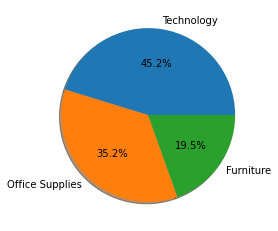

In [21]:
p = most_cat_profit.select(most_cat_profit["Category"])
o = most_cat_profit.select(most_cat_profit["Total Profit"])
l1 = [row["Category"] for row in p.collect()]
l2 = [row["Total Profit"] for row in o.collect()]

sizes=[663712.0816800011, 516615.9118999997, 286439.87820000004]
labels= "Technology", "Office Supplies", "Furniture"
plt.pie(sizes,labels=labels,shadow=True,autopct='%1.1f%%')
plt.savefig('category_profit.png', dpi=300, bbox_inches='tight')
plt.show()

# Most profit per country 

In [22]:
country_prof = data.select(data["Country"], data["Profit"])
most_country_prof = country_prof.groupBy(country_prof["Country"]).sum().withColumnRenamed("sum(Profit)", "Total Profit")
most_country_prof.orderBy(most_country_prof["Total Profit"], ascending = False).show()

+--------------+------------------+
|       Country|      Total Profit|
+--------------+------------------+
| United States|285707.60219999973|
|         China|150683.08499999996|
|         India|129071.83500000008|
|United Kingdom|111900.14999999997|
|        France|109029.00300000003|
|       Germany|107322.82049999999|
|     Australia| 103907.4330000001|
|        Mexico|102818.09752000004|
|         Spain| 54390.11999999997|
|   El Salvador| 42023.24319999998|
|          Cuba|38889.215480000006|
|     Nicaragua| 33401.44455999999|
|        Brazil| 30090.49896000002|
|     Guatemala|27944.686759999997|
|          Iran|26856.239999999998|
|       Austria|24341.700000000004|
|         Japan|24328.466999999993|
|       Morocco|22761.420000000006|
|        Russia|22536.449999999997|
|  South Africa|21936.629999999997|
+--------------+------------------+
only showing top 20 rows



In [23]:
prcountries=most_country_prof.rdd.map(lambda x: x[0]).collect()
prvs=most_country_prof.rdd.map(lambda x: x[1]).collect()

pdt=[dict(type="choropleth", autocolorscale=True, locations=prcountries, z=prvs, locationmode="country names", text=prcountries, colorbar= dict(title='Profit'))]
playout=dict(geo=dict(scope="world", projection=dict(type="natural earth"), showlakes=True, lakecolor='rgb(0,0,255)'))
fig=dict(data=pdt, layout=playout)
pio.show(fig)

# Most profit per market 

In [24]:
mark_prof = data.select(data["Market"], data["Profit"])
most_mark_prof = mark_prof.groupBy(mark_prof["Market"]).sum().withColumnRenamed("sum(Profit)", "Total Profit")
most_mark_prof.orderBy(most_mark_prof["Total Profit"], ascending = False).show()

+------+------------------+
|Market|      Total Profit|
+------+------------------+
|  APAC| 436000.0490000002|
|    EU| 372829.7414999994|
|    US|285707.60219999973|
| LATAM|221643.48707999976|
|Africa| 88871.63100000001|
|  EMEA|43897.971000000005|
|Canada|          17817.39|
+------+------------------+



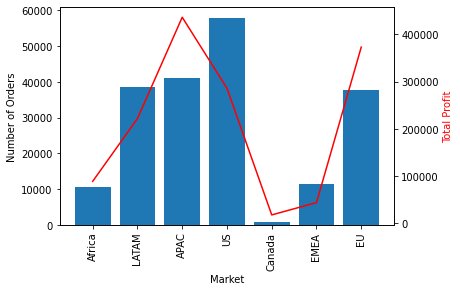

In [25]:
# p = most_mark_prof.select(most_mark_prof["Market"])
# o = most_mark_prof.select(most_mark_prof["Total Profit"])
# l1 = [row["Market"] for row in p.collect()]
# l2 = [row["Total Profit"] for row in o.collect()]
# plt.bar(l1, l2)
# plt.xticks(l1,rotation="vertical")
# plt.xlabel("Market")
# plt.ylabel("Total Profit")
# plt.show()

p = most_market.select(most_market["Market"])
o = most_market.select(most_market["Total Ordered"])
l1 = [row["Market"] for row in p.collect()]
l2 = [row["Total Ordered"] for row in o.collect()]

m = most_mark_prof.select(most_mark_prof["Market"])
n = most_mark_prof.select(most_mark_prof["Total Profit"])
l3 = [row["Market"] for row in m.collect()]
l4 = [row["Total Profit"] for row in n.collect()]

fig,ax2=plt.subplots()

ax1=ax2.twinx()
ax2.bar(l1, l2)
ax1.plot(l3, l4, 'r')
ax2.set_xlabel("Market")
ax2.set_ylabel("Number of Orders")
ax1.set_ylabel("Total Profit", color = "r")
ax2.set_xticklabels(l1,rotation='vertical')
plt.savefig('market.png', dpi=300, bbox_inches='tight')
plt.show()

# Most profit per segment

In [26]:
seg_prof = data.select(data["Segment"], data["Profit"])
most_seg_prof = seg_prof.groupBy(seg_prof["Segment"]).sum().withColumnRenamed("sum(Profit)", "Total Profit")
most_seg_prof.orderBy(most_seg_prof["Total Profit"], ascending = False).show()

+-----------+-----------------+
|    Segment|     Total Profit|
+-----------+-----------------+
|   Consumer|749564.4320600019|
|  Corporate|440659.1595600009|
|Home Office|276544.2801599999|
+-----------+-----------------+



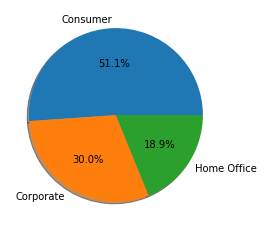

In [27]:
p = most_seg_prof.select(most_seg_prof["Segment"])
o = most_seg_prof.select(most_seg_prof["Total Profit"])
l1 = [row["Segment"] for row in p.collect()]
l2 = [row["Total Profit"] for row in o.collect()]

sizes=[749564.4320600019, 440659.1595600009, 276544.2801599999]
labels= "Consumer", "Corporate", "Home Office"
plt.pie(sizes,labels=labels,shadow=True,autopct='%1.1f%%')
plt.savefig('segment_profit.png', dpi=300, bbox_inches='tight')
plt.show()

# Month with most orders

In [28]:
date = data.select(data["Month"], data["Order ID"])
date.show()
# split_date=pyspark.sql.functions.split(df['Date'], '[-/]')

+-------+---------------+
|  Month|       Order ID|
+-------+---------------+
|2011-01|   AG-2011-2040|
|2011-01|  IN-2011-47883|
|2011-01|   HU-2011-1220|
|2011-01|IT-2011-3647632|
|2011-01|  IN-2011-47883|
|2011-01|  IN-2011-47883|
|2011-02|  IN-2011-30733|
|2011-02| CA-2011-115161|
|2011-02|   AO-2011-1390|
|2011-02|  ID-2011-56493|
|2011-02|  IN-2011-36074|
|2011-02| US-2011-118892|
|2011-02|   IR-2011-6550|
|2011-02|ES-2011-5268439|
|2011-02|  IN-2011-30733|
|2011-02| US-2011-118892|
|2011-02|ES-2011-5460465|
|2011-02|  IN-2011-30733|
|2011-02|  IN-2011-30733|
|2011-02|ES-2011-5268439|
+-------+---------------+
only showing top 20 rows



In [29]:
month_order = date.groupBy(date["Month"]).count()
month_orders = month_order.orderBy(month_order["Month"], ascending = True)
month_orders.show()

+-------+-----+
|  Month|count|
+-------+-----+
|2011-01|  433|
|2011-02|  378|
|2011-03|  539|
|2011-04|  564|
|2011-05|  566|
|2011-06|  917|
|2011-07|  495|
|2011-08|  878|
|2011-09| 1052|
|2011-10|  774|
|2011-11| 1139|
|2011-12| 1263|
|2012-01|  539|
|2012-02|  429|
|2012-03|  662|
|2012-04|  657|
|2012-05|  840|
|2012-06| 1136|
|2012-07|  659|
|2012-08| 1083|
+-------+-----+
only showing top 20 rows



# Monthly Profit 

In [30]:
month_profit = data.select(data["Month"], data["Profit"])
most_month_profit = month_profit.groupBy(month_profit["Month"]).sum().withColumnRenamed("sum(Profit)", "Total Profit")
most_month_profits = most_month_profit.orderBy(most_month_profit["Month"])
most_month_profits.show()

+-------+------------------+
|  Month|      Total Profit|
+-------+------------------+
|2011-01| 8288.699359999995|
|2011-02|       12341.64138|
|2011-03|       15224.26936|
|2011-04|12867.049380000002|
|2011-05|12177.699700000005|
|2011-06| 23496.96201999999|
|2011-07| 5501.384319999998|
|2011-08|       23749.56112|
|2011-09|35664.568739999995|
|2011-10|25969.080240000003|
|2011-11| 32599.23331999999|
|2011-12| 40577.51480000001|
|2012-01|10391.829640000004|
|2012-02|       14993.96008|
|2012-03| 17944.88155999999|
|2012-04|17674.858319999996|
|2012-05|29762.244140000006|
|2012-06|       34446.48642|
|2012-07|15485.839119999995|
|2012-08| 43523.92177999999|
+-------+------------------+
only showing top 20 rows



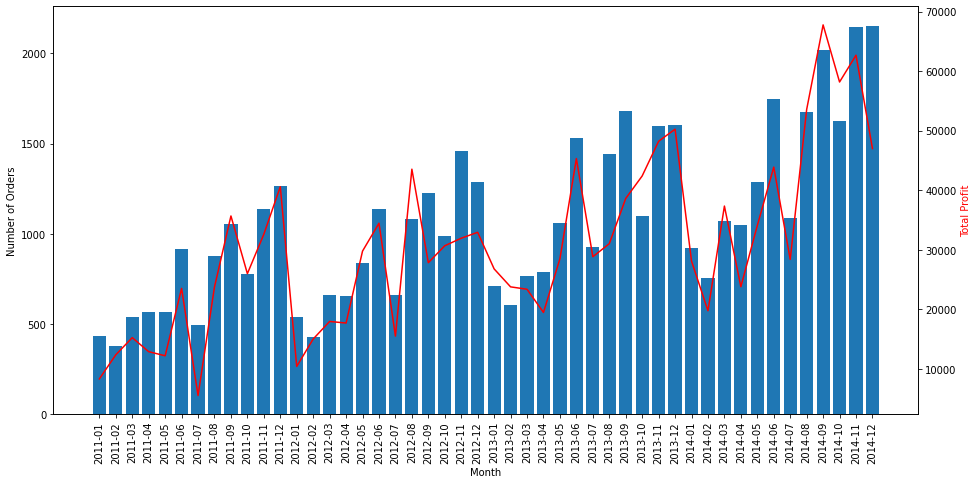

In [31]:
p = month_orders.select(month_orders["Month"])
o = month_orders.select(month_orders["count"])
l1 = [row["Month"] for row in p.collect()]
l2 = [row["count"] for row in o.collect()]

m = most_month_profits.select(most_month_profits["Month"])
n = most_month_profits.select(most_month_profits["Total Profit"])
l3 = [row["Month"] for row in m.collect()]
l4 = [row["Total Profit"] for row in n.collect()]

fig,ax2=plt.subplots()

ax1=ax2.twinx()
ax2.bar(l1, l2)
ax1.plot(l3, l4, 'r')
ax2.set_xlabel("Month")
ax2.set_ylabel("Number of Orders")
ax1.set_ylabel("Total Profit", color = "r")
ax2.set_xticklabels(l1,rotation='vertical')
fig.set_size_inches(15.5,7.5)
plt.savefig('month.png', dpi=300, bbox_inches='tight')
plt.show()

# Customer Orders

In [32]:
cust_order = data.select(data["Order ID"], data["Customer ID"])
most_cust_order = cust_order.distinct()
most_cust_order = most_cust_order.groupBy(most_cust_order["Customer ID"]).count()
top_cust = most_cust_order.orderBy(most_cust_order["count"], ascending = False).limit(20)
top_cust.show()

+-----------+-----+
|Customer ID|count|
+-----------+-----+
|   PO-18850|   41|
|   MP-17965|   39|
|   KH-16690|   39|
|   CK-12205|   38|
|   JH-15985|   38|
|   WB-21850|   38|
|   AR-10825|   38|
|   DW-13585|   37|
|   EM-13960|   37|
|   SC-20380|   37|
|   TP-21130|   37|
|   NS-18640|   37|
|   SZ-20035|   37|
|   FO-14305|   37|
|   BE-11335|   37|
|   ZC-21910|   37|
|   JG-15805|   37|
|   HM-14860|   37|
|   RB-19465|   36|
|   GH-14410|   36|
+-----------+-----+



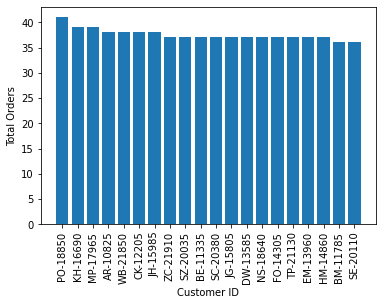

In [33]:
q = top_cust.select(top_cust["Customer ID"])
t = top_cust.select(top_cust["count"])
l5 = [row["Customer ID"] for row in q.collect()]
l6 = [row["count"] for row in t.collect()]

plt.bar(l5, l6)
plt.xticks(l5,rotation="vertical")
plt.xlabel("Customer ID")
plt.ylabel("Total Orders")
plt.savefig('customers.png', dpi=300, bbox_inches='tight')
plt.show()

# Days with most orders

In [34]:
dwmo=data.rdd.map(lambda x: (((datetime(int(x[1][:4]),int(x[1][5:7]),int(x[1][8:10])).strftime("%A")),datetime(int(x[1][:4]),int(x[1][5:7]),int(x[1][8:10])).weekday()),1)).\
reduceByKey(lambda x,y:x+y).sortBy(lambda x: x[0][1])
dwmo.collect()

[(('Monday', 0), 9177),
 (('Tuesday', 1), 9307),
 (('Wednesday', 2), 9017),
 (('Thursday', 3), 8871),
 (('Friday', 4), 9348),
 (('Saturday', 5), 4580),
 (('Sunday', 6), 990)]

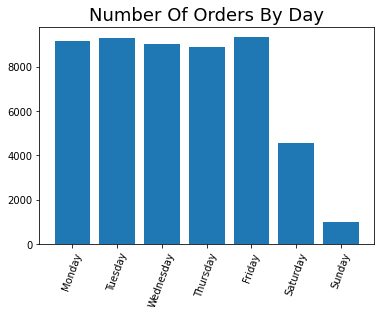

In [35]:
days=dwmo.map(lambda x: x[0][0]).collect()
dvls=dwmo.map(lambda x:x[1]).collect()

plt.bar(days, dvls)
plt.xticks(days, rotation=70,size=10)
plt.title("Number Of Orders By Day",size=18)
plt.show()

# Frequent Patterns

In [36]:
orders = data.select(data["Order ID"], data["Product ID"])
orders = orders.distinct()

In [37]:
rdd = orders.rdd.map(lambda x: (x[0], [x[1]]))
rdd.take(5)

[('CA-2011-101147', ['OFF-AP-10004249']),
 ('CA-2011-127964', ['TEC-PH-10004700']),
 ('CA-2011-125612', ['OFF-ST-10003221']),
 ('CA-2011-126361', ['OFF-AP-10003590']),
 ('US-2011-102281', ['TEC-CO-10001450'])]

In [38]:
rdd1 = rdd.reduceByKey(lambda x,y: x+y)
rdd1.take(5)

[('SA-2012-410', ['OFF-AVE-10004570', 'FUR-RUB-10002021']),
 ('ES-2013-5564504', ['TEC-PH-10003995', 'OFF-BI-10002047']),
 ('IR-2014-4680', ['TEC-STA-10004181', 'OFF-AVE-10004556']),
 ('US-2012-100930',
  ['OFF-EN-10004988',
   'TEC-PH-10003932',
   'TEC-CO-10004481',
   'OFF-FA-10000475']),
 ('ES-2013-3687340',
  ['TEC-MA-10003743',
   'OFF-EN-10001728',
   'OFF-AR-10000711',
   'OFF-PA-10002971',
   'OFF-AR-10002113'])]

In [39]:
order = sqlContext.createDataFrame(rdd1, ['Order ID', 'Product ID'])

In [40]:
fpGrowth = FPGrowth(itemsCol="Product ID", minSupport=0.00001, minConfidence=0.05)
model = fpGrowth.fit(order)
model.associationRules.show()

+--------------------+-----------------+----------+------------------+
|          antecedent|       consequent|confidence|              lift|
+--------------------+-----------------+----------+------------------+
|[OFF-SU-10003803,...|[FUR-FU-10002525]|       1.0|3576.4285714285716|
|[OFF-SU-10003803,...|[OFF-ST-10000007]|       1.0|          3129.375|
|[OFF-SU-10003803,...|[OFF-LA-10001830]|       1.0|          3129.375|
|[OFF-SU-10003803,...|[OFF-LA-10003141]|       1.0|           2086.25|
|[OFF-SU-10003803,...|[OFF-EN-10001976]|       1.0|            5007.0|
|[OFF-AR-10003448,...|[OFF-SU-10001698]|       1.0|            8345.0|
|[OFF-AR-10003448,...|[FUR-CH-10000026]|       1.0|            1669.0|
|[OFF-AR-10003448,...|[FUR-CH-10001322]|       1.0|            4172.5|
|[OFF-AR-10003448,...|[OFF-ST-10001357]|       1.0|            4172.5|
|[OFF-AR-10003448,...|[OFF-SU-10001709]|       1.0|            4172.5|
|[OFF-AR-10003448,...|[OFF-ST-10001824]|       1.0|            2503.5|
|[OFF-

In [41]:
model.freqItemsets.show()

+--------------------+----+
|               items|freq|
+--------------------+----+
|   [FUR-FU-10002937]|  14|
|[FUR-FU-10002937,...|   1|
|[FUR-FU-10002937,...|   1|
|[FUR-FU-10002937,...|   1|
|[FUR-FU-10002937,...|   1|
|[FUR-FU-10002937,...|   1|
|[FUR-FU-10002937,...|   1|
|[FUR-FU-10002937,...|   1|
|[FUR-FU-10002937,...|   1|
|[FUR-FU-10002937,...|   1|
|[FUR-FU-10002937,...|   1|
|[FUR-FU-10002937,...|   1|
|  [OFF-KIT-10003757]|   1|
|[OFF-KIT-10003757...|   1|
|[OFF-KIT-10003757...|   1|
|[OFF-KIT-10003757...|   1|
|  [OFF-CUI-10001032]|   2|
|[OFF-CUI-10001032...|   1|
|[OFF-CUI-10001032...|   1|
|[OFF-CUI-10001032...|   1|
+--------------------+----+
only showing top 20 rows

